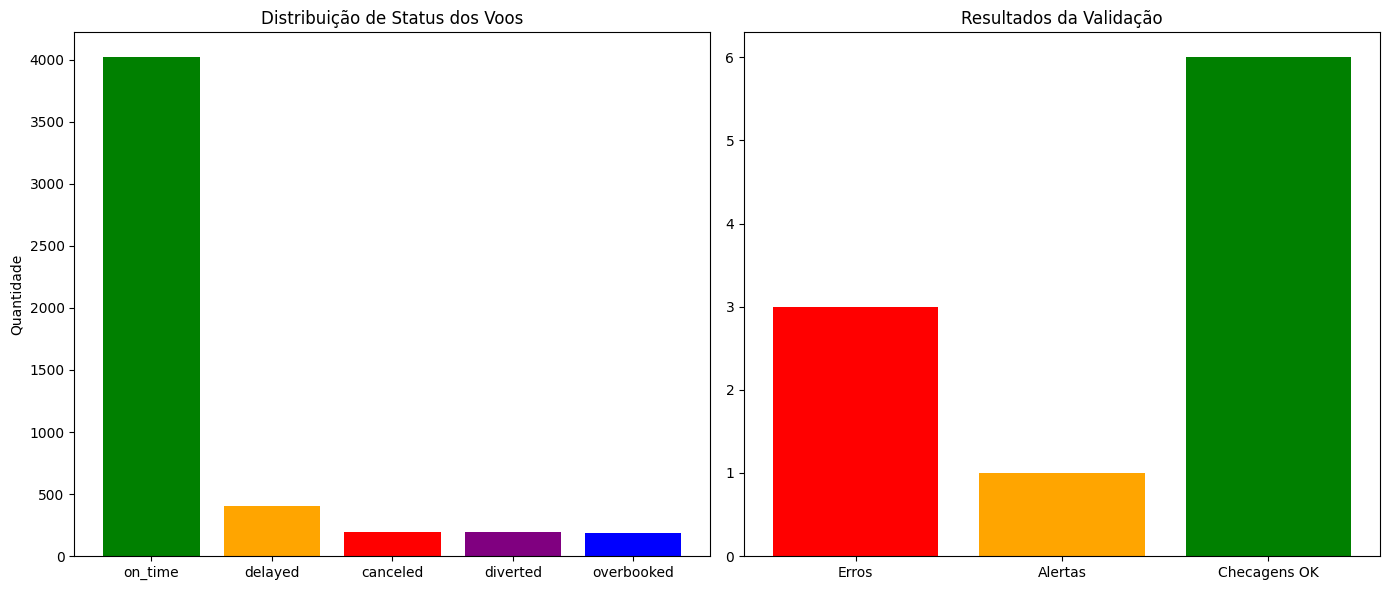

/tmp/ipykernel_16298/3650138674.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=problem_counts.index, y=problem_counts.values, palette='viridis')


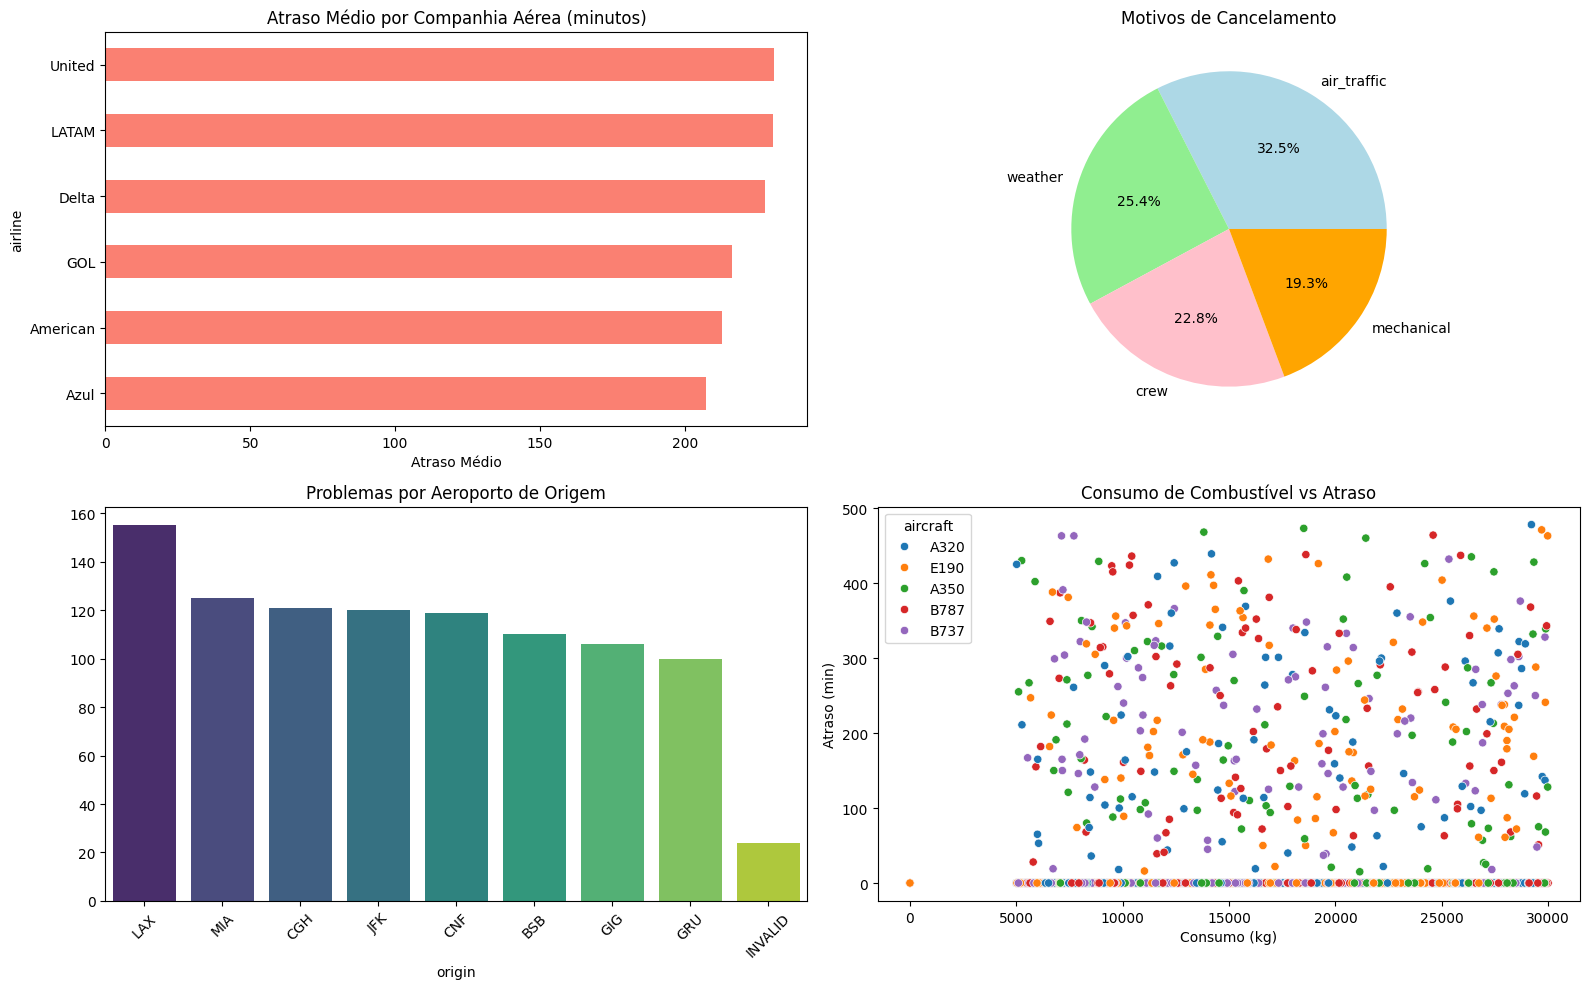


=== RESUMO DA VALIDAÇÃO ===
Total de voos: 5000
Voos com problemas: 980 (19.6%)

Erros encontrados (3):
- IDs de voo duplicados encontrados
- Durações inválidas encontradas: 130
- Origens inválidas encontradas: 141

Alertas encontrados (1):
- Tipo incorreto para delay_minutes. Esperado: float64, Encontrado: int64

Validação concluída. Relatórios salvos em data/reports/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import json


Path('data/reports').mkdir(parents=True, exist_ok=True)


class FlightDataValidator:
    def __init__(self, df):
        self.df = df
        self.results = {
            'checks': [],
            'errors': [],
            'warnings': [],
            'stats': {}
        }
    
    def validate_schema(self):
        """Valida estrutura básica dos dados"""
        required_cols = {
            'flight_id': 'object',
            'airline': 'object',
            'origin': 'object',
            'destination': 'object',
            'status': 'object',
            'flight_duration': 'int64',
            'delay_minutes': 'float64'
        }
        
        for col, dtype in required_cols.items():
            if col not in self.df.columns:
                self._add_error(f'Coluna faltando: {col}')
            elif str(self.df[col].dtype) != dtype:
                self._add_warning(f'Tipo incorreto para {col}. Esperado: {dtype}, Encontrado: {self.df[col].dtype}')
            else:
                self._add_check(f'Coluna {col} válida')
    
    def validate_values(self):
        """Valida conteúdo dos dados"""
        
        if self.df['flight_id'].duplicated().any():
            self._add_error('IDs de voo duplicados encontrados')
        
        
        invalid_durations = self.df[self.df['flight_duration'] <= 0]
        if len(invalid_durations) > 0:
            self._add_error(f'Durações inválidas encontradas: {len(invalid_durations)}')
        
        
        valid_airports = ['GRU', 'GIG', 'BSB', 'CNF', 'CGH', 'JFK', 'LAX', 'MIA']
        invalid_origins = self.df[~self.df['origin'].isin(valid_airports)]
        if len(invalid_origins) > 0:
            self._add_error(f'Origens inválidas encontradas: {len(invalid_origins)}')
    
    def validate_temporal_logic(self):
        """Valida consistência temporal"""
        
        time_issues = self.df[(self.df['status'] == 'on_time') & 
                            (self.df['actual_arrival'] > self.df['scheduled_arrival'] + pd.Timedelta(minutes=15))]
        if len(time_issues) > 0:
            self._add_error(f"Voos marcados como 'on_time' mas com atraso: {len(time_issues)}")
        
        
        canceled_with_arrival = self.df[(self.df['status'] == 'canceled') & 
                                      (self.df['actual_arrival'].notna())]
        if len(canceled_with_arrival) > 0:
            self._add_error(f"Voos cancelados com horário de chegada: {len(canceled_with_arrival)}")
    
    def calculate_stats(self):
        """Calcula métricas de qualidade"""
        self.results['stats']['total_flights'] = int(len(self.df))
        self.results['stats']['problem_flights'] = int(len(self.df[self.df['status'] != 'on_time']))
        self.results['stats']['problem_rate'] = float(self.results['stats']['problem_flights'] / self.results['stats']['total_flights'])
        
        if 'delayed' in self.df['status'].values:
            delays = self.df[self.df['status'] == 'delayed']['delay_minutes']
            self.results['stats']['avg_delay'] = float(delays.mean())
            self.results['stats']['max_delay'] = float(delays.max())
        
        if 'canceled' in self.df['status'].values:
            self.results['stats']['cancellation_reasons'] = self.df[self.df['status'] == 'canceled']['cancellation_reason'].value_counts().to_dict()
    
    def _add_error(self, msg):
        self.results['errors'].append(msg)
    
    def _add_warning(self, msg):
        self.results['warnings'].append(msg)
    
    def _add_check(self, msg):
        self.results['checks'].append(msg)
    
    def run_all_checks(self):
        """Executa todas as validações"""
        self.validate_schema()
        self.validate_values()
        self.validate_temporal_logic()
        self.calculate_stats()
        return self.results


try:
    flights = pd.read_csv('data/raw/flights.csv', 
                         parse_dates=['departure_time', 'scheduled_arrival', 'actual_arrival'])
except Exception as e:
    raise FileNotFoundError(f"Erro ao carregar dados: {str(e)}")


validator = FlightDataValidator(flights)
validation_results = validator.run_all_checks()


def convert_to_serializable(obj):
    if isinstance(obj, (np.integer)):
        return int(obj)
    elif isinstance(obj, (np.floating)):
        return float(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, (pd.Timestamp,)):
        return obj.isoformat()
    else:
        return obj


with open('data/reports/validation_results.json', 'w') as f:
    json.dump(validation_results, f, indent=2, default=convert_to_serializable)


def plot_validation_summary(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    
    status_counts = flights['status'].value_counts()
    ax1.bar(status_counts.index, status_counts.values, color=['green', 'orange', 'red', 'purple', 'blue'])
    ax1.set_title('Distribuição de Status dos Voos')
    ax1.set_ylabel('Quantidade')
    
    
    val_data = {
        'Erros': len(results['errors']),
        'Alertas': len(results['warnings']),
        'Checagens OK': len(results['checks'])
    }
    ax2.bar(val_data.keys(), val_data.values(), color=['red', 'orange', 'green'])
    ax2.set_title('Resultados da Validação')
    
    plt.tight_layout()
    plt.savefig('data/reports/validation_summary.png')
    plt.show()

plot_validation_summary(validation_results)


def create_quality_dashboard(df, results):
    plt.figure(figsize=(16, 10))
    
    
    plt.subplot(2, 2, 1)
    delays = df[df['status'] == 'delayed'].groupby('airline')['delay_minutes'].mean().sort_values()
    delays.plot(kind='barh', color='salmon')
    plt.title('Atraso Médio por Companhia Aérea (minutos)')
    plt.xlabel('Atraso Médio')
    
    
    plt.subplot(2, 2, 2)
    if 'canceled' in df['status'].values:
        df[df['status'] == 'canceled']['cancellation_reason'].value_counts().plot(
            kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'pink', 'orange'])
        plt.title('Motivos de Cancelamento')
        plt.ylabel('')
    
    
    plt.subplot(2, 2, 3)
    problem_flights = df[df['status'] != 'on_time']
    problem_counts = problem_flights['origin'].value_counts()
    sns.barplot(x=problem_counts.index, y=problem_counts.values, palette='viridis')
    plt.title('Problemas por Aeroporto de Origem')
    plt.xticks(rotation=45)
    
   
    plt.subplot(2, 2, 4)
    if 'fuel_consumption' in df.columns and 'delay_minutes' in df.columns:
        sns.scatterplot(data=df, x='fuel_consumption', y='delay_minutes', hue='aircraft')
        plt.title('Consumo de Combustível vs Atraso')
        plt.xlabel('Consumo (kg)')
        plt.ylabel('Atraso (min)')
    
    plt.tight_layout()
    plt.savefig('data/reports/quality_dashboard.png')
    plt.show()

create_quality_dashboard(flights, validation_results)


flights.to_csv('data/processed/validated_flights.csv', index=False)


print("\n=== RESUMO DA VALIDAÇÃO ===")
print(f"Total de voos: {len(flights)}")
print(f"Voos com problemas: {validation_results['stats']['problem_flights']} ({validation_results['stats']['problem_rate']:.1%})")
print(f"\nErros encontrados ({len(validation_results['errors'])}):")
for error in validation_results['errors']:
    print(f"- {error}")
    
print(f"\nAlertas encontrados ({len(validation_results['warnings'])}):")
for warning in validation_results['warnings']:
    print(f"- {warning}")

print("\nValidação concluída. Relatórios salvos em data/reports/")